In [1]:
#!pip install arrow
import numpy as np
import pandas as pd
from pandasql import sqldf
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima_model import ARIMA
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import arrow


In [2]:
login_times = pd.read_json('logins.json')
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
login_times

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [4]:
login_times[login_times.login_time.isna()==True]

,login_time


In [5]:
df = login_times.resample('15T', on='login_time').count()

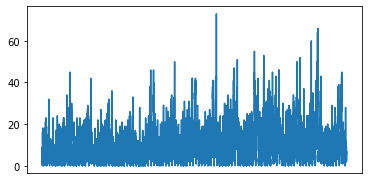

In [6]:
#intervals = intervals.set_index(login_time)

fig, ax = plt.subplots()
ax.set_xticks(df.login_time.values)
ax.set_xticklabels(df.index.values)
fig.subplots_adjust(bottom=0.3)

plt.xticks(rotation=90)
plt.plot(df)



#intervals.plot(figsize=(500,5))

In [7]:
df.head(-5)

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 16:30:00,4
1970-04-13 16:45:00,3
1970-04-13 17:00:00,5


### Yearly Trend
There are more people who rides bikes in april than march and march than february
There is an increase in two days a week ususally. Which may be weekends.
On second week of february there is increase in a third day which I think might be a monday feb 14 valentines day.
In Pasoville lovers love to bike on valentines day 
There is an increase in everyday on third week of march which might be spring break. 

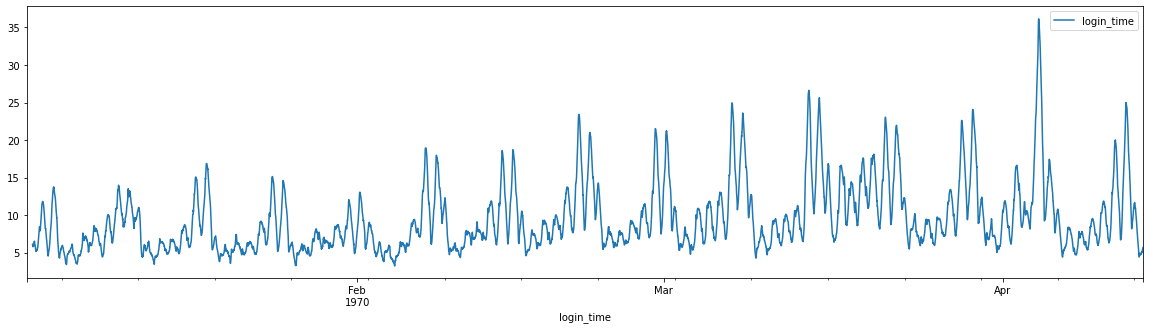

In [8]:
moving_average = df.rolling(window=50).mean()
moving_average.plot(figsize=(20, 5))

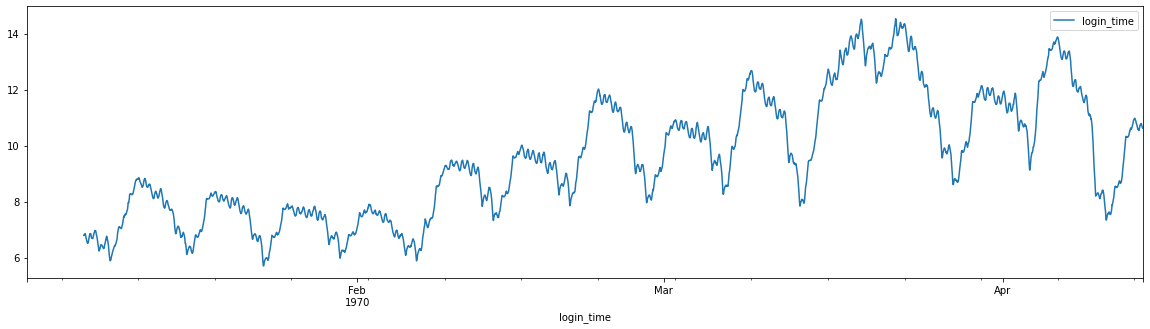

In [9]:
moving_average = df.rolling(window=500).mean()
moving_average.plot(figsize=(20, 5))

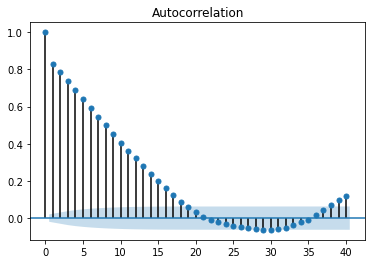

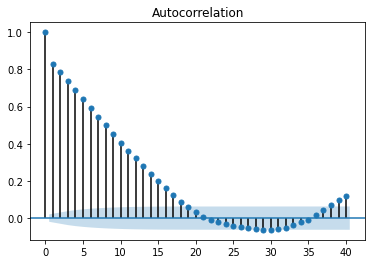

In [10]:
# Arima(p,d,q)
# Plot_acf will be used to identify the q
# d is the number we are going to give for correlation between months
plot_acf(df.login_time)

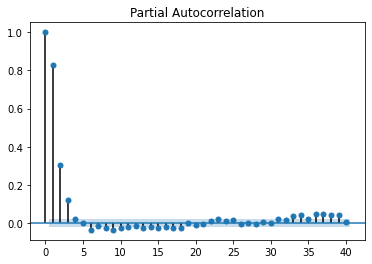

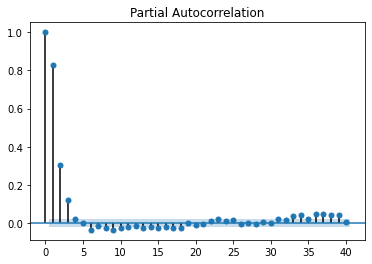

In [11]:
plot_pacf(df.login_time)

In [12]:
# p= 2,3  d=0,1    q=2,3,4
#train, test = train_test_split(temp_test.temperature, test_size=0.2)

train = df[:8000]
test = df[8000:]

In [13]:
p=d=q=range(0, 6)
pdq = list(itertools.product(p,d,q))

In [14]:
'''
for param in pdq:
    try:
        temp_model = ARIMA(train, order=param)
        temp_model_fit = temp_model.fit()
        print(param, temp_model_fit.aic)
    except:
        continue
'''

'\nfor param in pdq:\n    try:\n        temp_model = ARIMA(train, order=param)\n        temp_model_fit = temp_model.fit()\n        print(param, temp_model_fit.aic)\n    except:\n        continue\n'

### ARIMA
The lowest AIC has been reached by p, d, q, values of 3, 1, 3 respectively.

In [15]:
model = ARIMA(df, order=(3,1,3))
model_fit = model.fit()
print('AIC = ', model_fit.aic)
forecast = model_fit.forecast(steps=1788)[0]
print('ARIMA RMSE = ',np.sqrt(mean_squared_error(test, forecast)))

AIC =  56726.991351444914
ARIMA RMSE =  9.862221555763206


In [16]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.login_time   No. Observations:                 9787
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -28355.496
Method:                       css-mle   S.D. of innovations              4.384
Date:                Sat, 27 Feb 2021   AIC                          56726.991
Time:                        21:04:11   BIC                          56784.502
Sample:                    01-01-1970   HQIC                         56746.479
                         - 04-13-1970                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0006      0.000      3.796      0.000       0.000       0.001
ar.L1.D.login_time     0.5964        nan        nan        nan         nan         nan
ar.L2.D.login_time  

In [17]:
df['time'] = df.index
df['hour'] = df.time.apply(lambda x: x.hour)

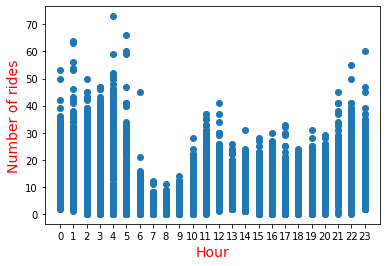

In [18]:
plt.xticks(np.arange(min(df.hour), max(df.hour)+1, 1.0))
plt.xlabel('Hour', fontsize=14, c='r')
plt.ylabel('Number of rides', fontsize=14, c='r')
plt.scatter(df.hour, df.login_time)

### Daily Trend
When the data was visualized by hours in the day we can see that there are more rides during the evening than day time.
Especially form 6am to 10am there is a decline of drivers. Starting from 9pm the number or drivers starts increasing.
Its peak is at 4am.